In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 

In [3]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 144

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [4]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [5]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' and adds 2 copys of it 
  """
  image = tf.cast(image, tf.float32)
  return (tf.image.resize(image, [128,128]), tf.image.resize(image, [128,128]), image ), label 

In [6]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to augmented training data
train_data_augmented = train_data_augmented.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size = tf.data.AUTOTUNE)

train_data_augmented

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

# Create checkpoint callback

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='ensemble_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

# Create ensemble model

In [7]:
# Load models
model_1 = tf.keras.models.load_model(r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_AVG_1.h5")
model_2 = tf.keras.models.load_model(r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_AVG_2.h5")
model_3 = tf.keras.models.load_model(r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_144p_B7.h5")
model_1.trainable = False
model_2.trainable = False
model_3.trainable = False

#renaming input layers
for i, modello in enumerate([model_1, model_2, model_3]):
    num_layer = f'{i+1}'
    for layer in modello.layers:
        layer._name = layer.name + '_' + num_layer
    print(modello.layers)

[<keras.src.engine.input_layer.InputLayer object at 0x7941b8dc7190>, <keras.src.layers.preprocessing.image_preprocessing.RandomFlip object at 0x79418c2d6b90>, <keras.src.layers.preprocessing.image_preprocessing.RandomBrightness object at 0x79418c2d68c0>, <keras.src.layers.preprocessing.image_preprocessing.RandomContrast object at 0x79418c2d63e0>, <keras.src.engine.functional.Functional object at 0x79418c2d5ff0>, <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79418c2d6bf0>, <keras.src.layers.core.dense.Dense object at 0x7941806ce2c0>, <keras.src.layers.regularization.dropout.Dropout object at 0x794145be6c20>, <keras.src.layers.core.dense.Dense object at 0x794134b28970>]
[<keras.src.engine.input_layer.InputLayer object at 0x794134b6eaa0>, <keras.src.layers.preprocessing.image_preprocessing.RandomFlip object at 0x7941806ebee0>, <keras.src.layers.preprocessing.image_preprocessing.RandomBrightness object at 0x79418023b4c0>, <keras.src.layers.preprocess

In [8]:
from tensorflow.keras import layers

# concatenating the models
ensemble_layer = layers.Concatenate(name="ensemble_concat")([ model_1.output, model_2.output, model_3.output])
x = layers.Dense(32, activation='relu')(ensemble_layer)
x = layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# creating the model
ensemble_model = tf.keras.Model(
    inputs=[model_1.input, model_2.input, model_3.input],
    outputs=outputs,
    name='ensemble_model'
)

#compile the model
ensemble_model.compile(
                            optimizer = tf.keras.optimizers.Adam(), 
                            loss = tf.keras.losses.categorical_crossentropy,
                            metrics = ['accuracy']
    )

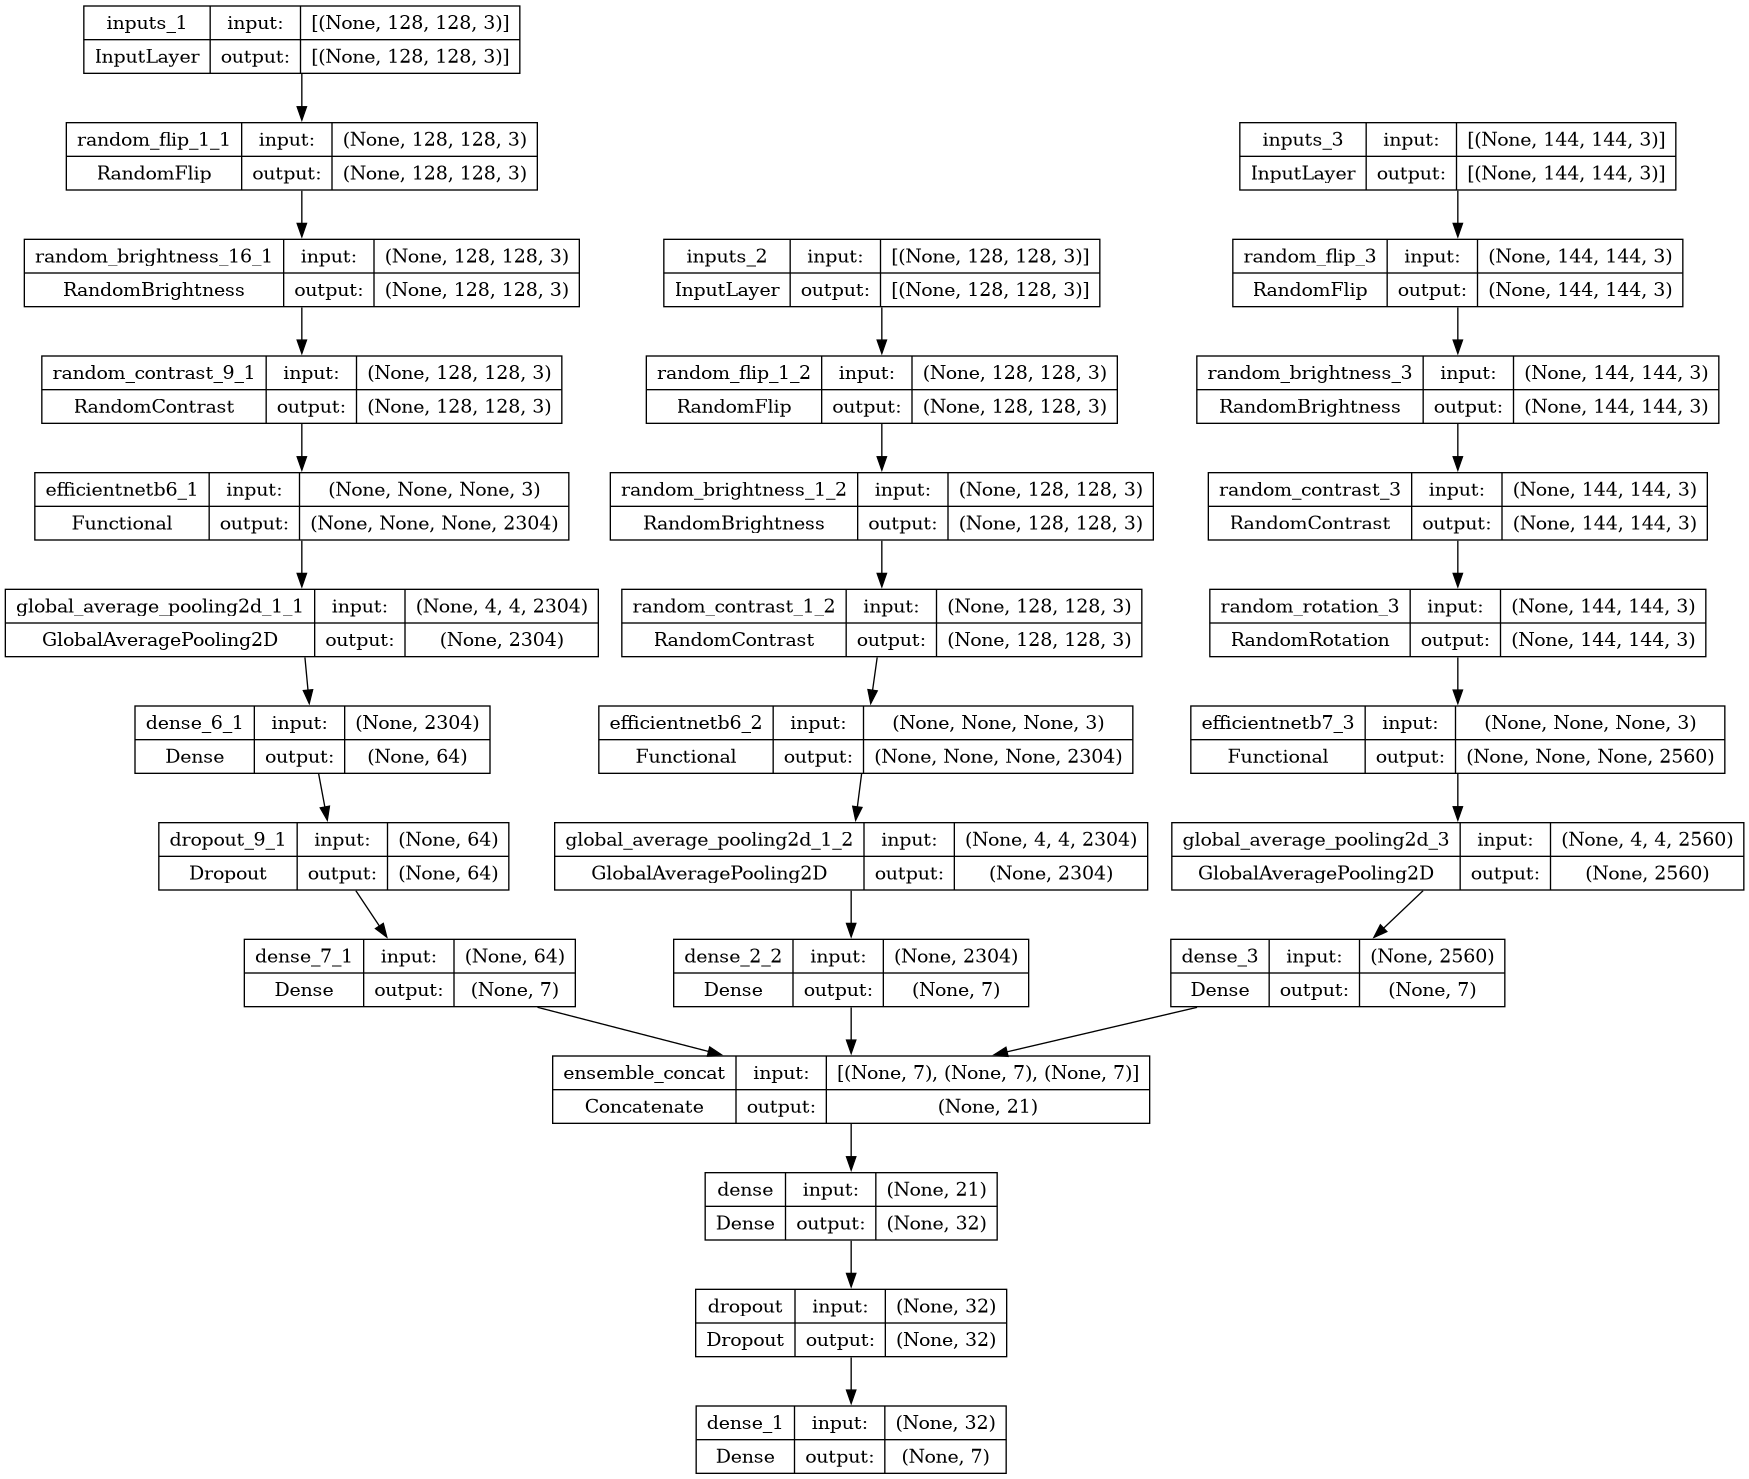

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(ensemble_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_fine_tuning = ensemble_model.fit(
                                    train_data_augmented,
                                    epochs=8,
                                    validation_data=valid_data,
                                    validation_steps=len(valid_data),
                                    callbacks=[checkpoint_callback]
)

Epoch 1/8


2024-01-22 17:25:09.529892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble_model/efficientnetb6_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.4299 - accuracy: 0.5097
Epoch 1: val_accuracy improved from -inf to 0.40542, saving model to ensemble_best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


746/746 [==============================] - 388s 422ms/step - loss: 1.4299 - accuracy: 0.5097 - val_loss: 1.6859 - val_accuracy: 0.4054
Epoch 2/8
746/746 [==============================] - ETA: 0s - loss: 1.2756 - accuracy: 0.5562
Epoch 2: val_accuracy improved from 0.40542 to 0.41084, saving model to ensemble_best_model.h5
746/746 [==============================] - 299s 398ms/step - loss: 1.2756 - accuracy: 0.5562 - val_loss: 1.7097 - val_accuracy: 0.4108
Epoch 3/8
746/746 [==============================] - ETA: 0s - loss: 1.2559 - accuracy: 0.5652
Epoch 3: val_accuracy did not improve from 0.41084
746/746 [==============================] - 295s 394ms/step - loss: 1.2559 - accuracy: 0.5652 - val_loss: 1.7204 - val_accuracy: 0.4079
Epoch 4/8
746/746 [==============================] - ETA: 0s - loss: 1.2547 - accuracy: 0.5612
Epoch 4: val_accuracy did not improve from 0.41084
746/746 [==============================] - 295s 394ms/step - loss: 1.2547 - accuracy: 0.5612 - val_loss: 1.7262 -

# Evaluate

In [7]:
ensemble_model = tf.keras.models.load_model(r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\ensemble_best_model.h5")
ensemble_model.evaluate(test_data)

64/64 [==============================] - 269s 4s/step - loss: 1.8322 - accuracy: 0.3828


[1.8322376012802124, 0.38275861740112305]

## Confusion matrix

In [10]:
# Create valid labels and predictions
valid_labels = []
for images, labels in valid_data.unbatch():
  valid_labels.append(tf.argmax(labels).numpy())
valid_pred_probs = ensemble_model.predict(valid_data)
valid_predictions = tf.argmax(valid_pred_probs, axis=1)

64/64 [==============================] - 290s 4s/step


array([[0.49655172, 0.1       , 0.05862069, 0.02758621, 0.15862069,
        0.08275862, 0.07586207],
       [0.10344828, 0.54482759, 0.1       , 0.02758621, 0.10344828,
        0.04482759, 0.07586207],
       [0.13793103, 0.09655172, 0.21034483, 0.04482759, 0.27241379,
        0.15172414, 0.0862069 ],
       [0.06551724, 0.07586207, 0.06206897, 0.36206897, 0.14482759,
        0.24827586, 0.04137931],
       [0.12758621, 0.11034483, 0.05517241, 0.04482759, 0.38275862,
        0.18965517, 0.08965517],
       [0.07586207, 0.03103448, 0.11034483, 0.08965517, 0.23793103,
        0.37586207, 0.07931034],
       [0.08275862, 0.06896552, 0.06896552, 0.02758621, 0.14482759,
        0.10344828, 0.50344828]])

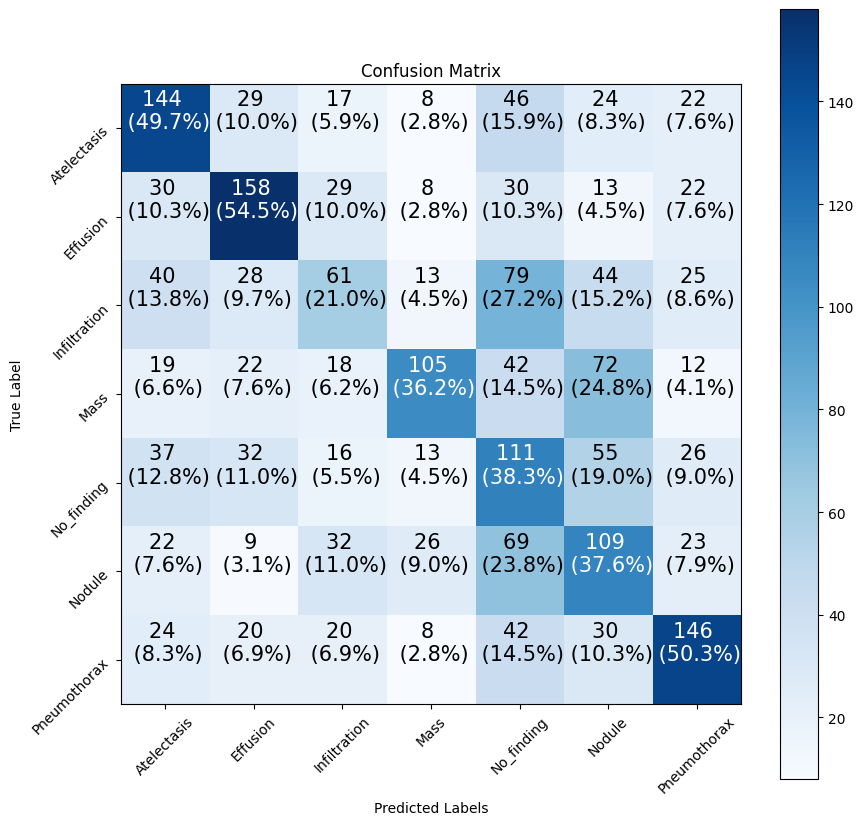

In [11]:
from helper_functions import plot_confusion_matrix
plot_confusion_matrix(valid_labels, valid_predictions, class_names)